In [234]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from datetime import datetime, timedelta
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [235]:
electoral_votes = {
    "Alabama": 9,
    "Alaska": 3,
    "Arizona": 11,
    "Arkansas": 6,
    "California": 54,
    "Colorado": 10,
    "Connecticut": 7,
    "Delaware": 3,
    "District of Columbia": 3,
    "Florida": 30,
    "Georgia": 16,
    "Hawaii": 4,
    "Idaho": 4,
    "Illinois": 19,
    "Indiana": 11,
    "Iowa": 6,
    "Kansas": 6,
    "Kentucky": 8,
    "Louisiana": 8,
    "Maine": 2,
    "Maine CD-1": 1,
    "Maine CD-2": 1,
    "Maryland": 10,
    "Massachusetts": 11,
    "Michigan": 15,
    "Minnesota": 10,
    "Mississippi": 6,
    "Missouri": 10,
    "Montana": 4,
    "Nebraska": 2,
    "Nebraska CD-1": 1,
    "Nebraska CD-2": 1,
    "Nebraska CD-3": 1,
    "Nevada": 6,
    "New Hampshire": 4,
    "New Jersey": 14,
    "New Mexico": 5,
    "New York": 28,
    "North Carolina": 16,
    "North Dakota": 3,
    "Ohio": 17,
    "Oklahoma": 7,
    "Oregon": 8,
    "Pennsylvania": 19,
    "Rhode Island": 4,
    "South Carolina": 9,
    "South Dakota": 3,
    "Tennessee": 11,
    "Texas": 40,
    "Utah": 6,
    "Vermont": 3,
    "Virginia": 13,
    "Washington": 12,
    "West Virginia": 4,
    "Wisconsin": 10,
    "Wyoming": 3,
}

# sum of all electoral votes
print(f"Total Electoral Votes: {sum(electoral_votes.values())}")
print(f"Majorty Electoral Votes: {int(sum(electoral_votes.values()) / 2+1)}")

Total Electoral Votes: 538
Majorty Electoral Votes: 270


['Kamala Harris' 'Donald Trump']
['Massachusetts' nan 'North Carolina' 'Arizona' 'Georgia' 'Michigan'
 'Nevada' 'Pennsylvania' 'Wisconsin' 'Nebraska' 'New Mexico' 'Colorado'
 'California' 'Utah' 'Maryland' 'New Hampshire' 'Virginia' 'Maine'
 'Maine CD-1' 'Maine CD-2' 'South Carolina' 'Washington' 'Oklahoma'
 'Texas' 'Florida' 'Ohio' 'Minnesota' 'Nebraska CD-1' 'Nebraska CD-2'
 'Nebraska CD-3' 'Tennessee' 'Illinois' 'Indiana' 'New Jersey' 'New York'
 'Missouri' 'Wyoming' 'Montana' 'Alaska' 'South Dakota' 'Oregon' 'Kansas'
 'North Dakota' 'Iowa' 'Delaware' 'Rhode Island' 'Connecticut' 'Arkansas'
 'West Virginia' 'Vermont' 'Louisiana' 'Hawaii' 'Alabama' 'Idaho'
 'Kentucky' 'Mississippi']


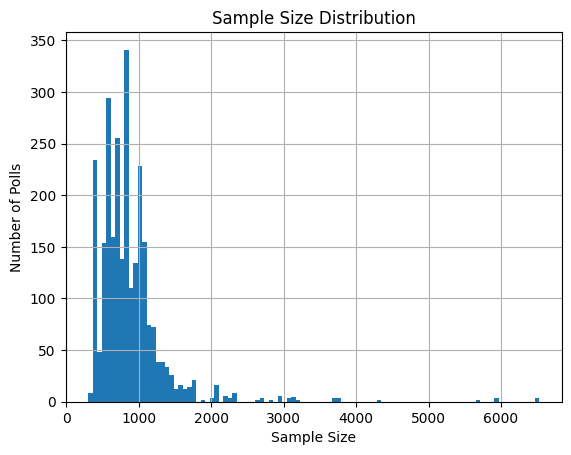

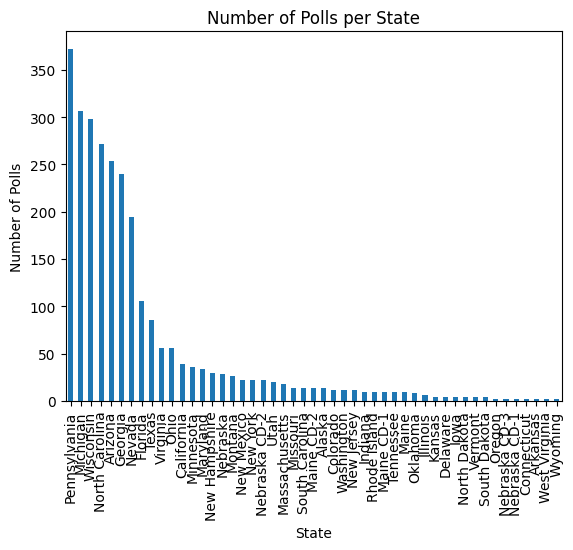

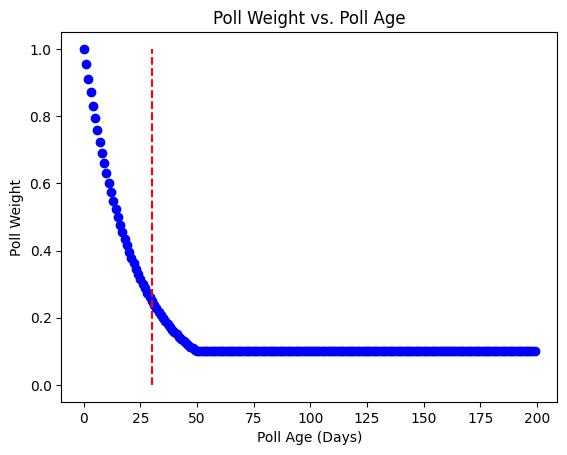

In [236]:
# Read the polling data
df = pd.read_csv('president_polls.csv')

# Filter for general election polls between Trump and Harris
df = df[df['stage'] == 'general']
df = df[df['candidate_name'].isin(['Donald Trump', 'Kamala Harris'])]

#print unique candidates
print(df['candidate_name'].unique())

# rpint states unique values
print(df['state'].unique())

# If state is NaN, replace it with 'National'
df['state'] = df['state'].fillna('National')

# remove rows with National
df = df[df['state'] != 'National']

# Convert 'end_date' to datetime
df['end_date'] = pd.to_datetime(df['end_date'])

# Keep only polls from the last 6 months (or adjust as needed)
recent_polls_cutoff = df['end_date'].max() - timedelta(days=90)
df = df[df['end_date'] >= recent_polls_cutoff]

# histogram of sample size
df['sample_size'].hist(bins=100)
plt.xlabel('Sample Size')
plt.ylabel('Number of Polls')
plt.title('Sample Size Distribution')
plt.show()

#print number of polls per state histogram wihtout national
df['state'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of Polls')
plt.title('Number of Polls per State')
plt.show()

# Get the most recent date in the dataset
most_recent_date = df['end_date'].max()

# Calculate the age of each poll in days
df['poll_age'] = (most_recent_date - df['end_date']).dt.days

# Function to calculate poll weight based on age
def weight_poll(age, halflife=15, min_weight=0.1):
    weight = 0.5 ** (age / halflife)
    return max(weight, min_weight)

df['weight'] = df['poll_age'].apply(weight_poll)

# Merge the sample sizes and weights
df['weighted_sample_size'] = df['sample_size'] * df['weight']

# Ensure sample_size is not zero to avoid division by zero
df = df[df['sample_size'] >= 50]

# plot weight_poll function
ages = np.arange(0, 200)
for a in ages:
    plt.plot(a, weight_poll(a), 'bo')
plt.xlabel('Poll Age (Days)')
plt.ylabel('Poll Weight')
plt.title('Poll Weight vs. Poll Age')
plt.vlines(30, 0, 1, linestyles='dashed', colors='r', label='14 days')
plt.show()





In [237]:
# Group by state, poll_id, and candidate to get aggregated percentages
grouped = df.groupby(['state', 'poll_id', 'candidate_name']).agg({
    'pct': 'mean',
    'sample_size': 'first',
    'weight': 'first',
    'weighted_sample_size': 'first'
}).reset_index()

# Pivot to get candidates as columns
df_pivot = grouped.pivot_table(
    index=['state', 'poll_id', 'sample_size', 'weight', 'weighted_sample_size'],
    columns='candidate_name',
    values='pct'
).reset_index()

# Fill missing values with zeros
df_pivot = df_pivot.dropna(subset=['Donald Trump', 'Kamala Harris'])


In [238]:

# Calculate weighted average pct and total weighted sample size per state
state_grouped = df_pivot.groupby('state').apply(
    lambda x: pd.Series({
        'Trump_pct': np.average(x['Donald Trump'], weights=x['weighted_sample_size']),
        'Harris_pct': np.average(x['Kamala Harris'], weights=x['weighted_sample_size']),
        'total_weighted_sample_size': x['weighted_sample_size'].sum()
    })
).reset_index()


min_effective_sample_size = 300  # You can adjust this value

state_grouped['effective_sample_size'] = state_grouped['total_weighted_sample_size'].clip(lower=min_effective_sample_size)

def calc_se(pct, n):
    p = pct / 100
    se = np.sqrt(p * (1 - p) / n) * 100  # SE in percentage points
    return se

state_grouped['Trump_se'] = state_grouped.apply(
    lambda x: calc_se(x['Trump_pct'], x['effective_sample_size']), axis=1)
state_grouped['Harris_se'] = state_grouped.apply(
    lambda x: calc_se(x['Harris_pct'], x['effective_sample_size']), axis=1)

max_se = 5  # Maximum standard error in percentage points

state_grouped['Trump_se'] = state_grouped['Trump_se'].clip(upper=max_se)
state_grouped['Harris_se'] = state_grouped['Harris_se'].clip(upper=max_se)


harris_states = ['California', 'New York', 'Washington', 'District of Columbia', 'Massachusetts', 'Hawaii', 'Vermont', 'Maryland', 'Rhode Island', 'Connecticut', 'Illinois', 'Delaware']
trump_states = ['Alabama', 'Arkansas', 'Idaho', 'Kentucky', 'Louisiana', 'North Dakota', 'Oklahoma', 'South Dakota', 'Tennessee', 'West Virginia', 'Wyoming', 'Mississippi', 'Utah', 'Alaska']

# Initialize a list to hold new rows for states that need to be added
new_rows = []

for state in harris_states + trump_states:
    if state not in state_grouped['state'].values:
        # Create a dictionary for the new row based on expected results
        if state in harris_states:
            new_rows.append({
                'state': state,
                'Trump_pct': 10,
                'Harris_pct': 90,
                'effective_sample_size': min_effective_sample_size,
                'Trump_se': 5,  # Increase SE to reflect uncertainty
                'Harris_se': 5,
                'total_weighted_sample_size': min_effective_sample_size
            })
        elif state in trump_states:
            new_rows.append({
                'state': state,
                'Trump_pct': 90,
                'Harris_pct': 10,
                'effective_sample_size': min_effective_sample_size,
                'Trump_se': 5,
                'Harris_se': 5,
                'total_weighted_sample_size': min_effective_sample_size
            })

# Concatenate the original DataFrame with the new rows
state_grouped = pd.concat([state_grouped, pd.DataFrame(new_rows)], ignore_index=True)

# see if all states are in the electoral votes
for state in state_grouped['state']:
    if state not in electoral_votes:
        print(f"Missing electoral votes for {state}")

# see if all states are in the state_grouped
for state in electoral_votes:
    if state not in state_grouped['state'].values:
        print(f"Missing polling data for {state}")


state_grouped = state_grouped.sort_values('state')

assert len(state_grouped) == len(electoral_votes)

print(state_grouped[['state', 'Trump_pct', 'Harris_pct', 'Trump_se', 'Harris_se', 'total_weighted_sample_size']])



                   state  Trump_pct  Harris_pct  Trump_se  Harris_se  \
51               Alabama  90.000000   10.000000  5.000000   5.000000   
0                 Alaska  52.251891   43.830231  1.137357   1.129811   
1                Arizona  48.676988   47.039093  0.323645   0.323190   
2               Arkansas  55.000000   40.000000  2.872281   2.828427   
3             California  34.703531   58.274470  0.512320   0.530701   
4               Colorado  41.802285   55.011318  1.366764   1.378536   
5            Connecticut  37.000000   53.000000  2.787472   2.881551   
6               Delaware  36.547676   54.657925  2.780309   2.874198   
49  District of Columbia  10.000000   90.000000  5.000000   5.000000   
7                Florida  50.930938   45.326052  0.399172   0.397493   
8                Georgia  48.618422   47.278371  0.310938   0.310595   
50                Hawaii  10.000000   90.000000  5.000000   5.000000   
52                 Idaho  90.000000   10.000000  5.000000   5.00

In [239]:
def simulate_state_with_districts(state, means, ses, candidates, electoral_votes, total_evs, state_ev, district_evs, state_win_counts):
    # Statewide vote
    with pm.Model():
        p = pm.TruncatedNormal('p', mu=means, sigma=ses, lower=0, upper=100)
        sim_pcts = pm.draw(p)
        winner = candidates[np.argmax(sim_pcts)]
        total_evs[winner] += electoral_votes[state_ev]
        # Update state win counts for the statewide vote
        state_win_counts[state_ev][winner] += 1

    # Simulate districts
    for district in district_evs:
        # Introduce variability for districts
        district_means = means  # Assuming no district-level polling data
        district_ses = [se + 2 for se in ses]  # Increase SE to reflect higher uncertainty
        with pm.Model():
            p = pm.TruncatedNormal('p', mu=district_means, sigma=district_ses, lower=0, upper=100)
            sim_pcts = pm.draw(p)
            winner = candidates[np.argmax(sim_pcts)]
            total_evs[winner] += electoral_votes[district]
            # Update state win counts for the district
            state_win_counts[district][winner] += 1
    return total_evs


In [240]:
# Initialize per-state win counts
state_win_counts = {state: {'Donald Trump': 0, 'Kamala Harris': 0} for state in electoral_votes.keys()}

# Update the simulation loop
simulation_results = {'Donald Trump': 0, 'Kamala Harris': 0}
num_simulations = 100  # Increase the number of simulations for better accuracy

for _ in tqdm(range(num_simulations)):
    total_electoral_votes = {'Donald Trump': 0, 'Kamala Harris': 0}
    for _, row in state_grouped.iterrows():
        state = row['state']
        candidates = ['Donald Trump', 'Kamala Harris']
        means = [row['Trump_pct'], row['Harris_pct']]
        ses = [row['Trump_se'], row['Harris_se']]

        if state == 'National' or np.isnan(means).any():
            continue  # Skip national polls or states with missing data

        # Handle Maine and Nebraska separately
        if state == 'Maine':
            state_ev = 'Maine'
            district_evs = ['Maine CD-1', 'Maine CD-2']
            total_electoral_votes = simulate_state_with_districts(
                state, means, ses, candidates, electoral_votes, total_electoral_votes, state_ev, district_evs, state_win_counts)
        elif state == 'Nebraska':
            state_ev = 'Nebraska'
            district_evs = ['Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3']
            total_electoral_votes = simulate_state_with_districts(
                state, means, ses, candidates, electoral_votes, total_electoral_votes, state_ev, district_evs, state_win_counts)
        else:
            # Other states
            with pm.Model():
                # Priors
                p = pm.TruncatedNormal('p', mu=means, sigma=ses, lower=0, upper=100)
                # Simulate one sample
                sim_pcts = pm.draw(p)
                winner = candidates[np.argmax(sim_pcts)]
                ev = electoral_votes.get(state, 0)
                total_electoral_votes[winner] += ev
                # Update state win counts
                state_win_counts[state][winner] += 1
    # Determine the winner of the simulation
    simulation_winner = max(total_electoral_votes, key=total_electoral_votes.get)
    simulation_results[simulation_winner] += 1


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


In [241]:
# Calculate win probabilities
for candidate in simulation_results:
    win_probability = (simulation_results[candidate] / num_simulations) * 100
    print(f"{candidate} win probability: {win_probability:.2f}%")


Donald Trump win probability: 26.00%
Kamala Harris win probability: 74.00%


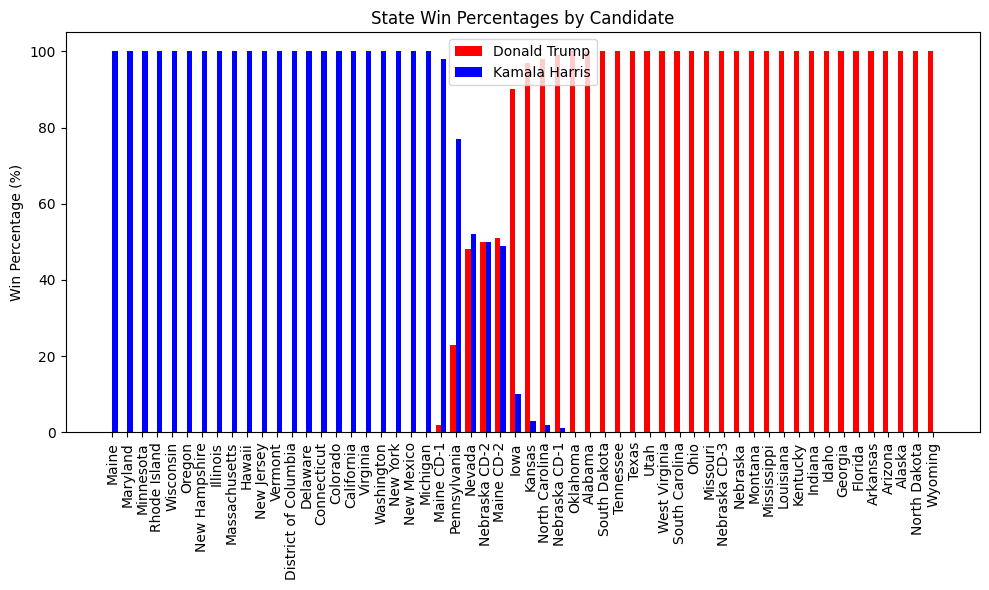

In [245]:
# Convert state_win_counts to a DataFrame
state_win_df = pd.DataFrame.from_dict(state_win_counts, orient='index')
state_win_df['Total'] = state_win_df['Donald Trump'] + state_win_df['Kamala Harris']

# Calculate the win probabilities
state_win_df['Trump_Win_Percent'] = (state_win_df['Donald Trump'] / state_win_df['Total']) * 100
state_win_df['Harris_Win_Percent'] = (state_win_df['Kamala Harris'] / state_win_df['Total']) * 100

# Reset index to have 'state' as a column
state_win_df.reset_index(inplace=True)
state_win_df.rename(columns={'index': 'State'}, inplace=True)

import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by Trump's win percentage
state_win_df.sort_values('Trump_Win_Percent', inplace=True)

# Define the positions and width for the bars
ind = np.arange(len(state_win_df))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Trump
ax.bar(ind - width/2, state_win_df['Trump_Win_Percent'], width, label='Donald Trump', color='red')

# Plot bars for Harris
ax.bar(ind + width/2, state_win_df['Harris_Win_Percent'], width, label='Kamala Harris', color='blue')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Win Percentage (%)')
ax.set_title('State Win Percentages by Candidate')
ax.set_xticks(ind)
ax.set_xticklabels(state_win_df['State'], rotation='vertical')
ax.legend()

plt.tight_layout()
plt.show()

